# Lymphoid_No2_clustering-annotation

* version 10th Aug 2021

## Import required modules

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy.external as sce

In [2]:
sc.logging.print_header()
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.0 louvain==0.7.0 leidenalg==0.8.3


## Read integrated data

In [6]:
integ = sc.read_h5ad('/nfs/team205/kk18/DCM/anndata/Lymohoid_HCA-DCM-scVI_210311.h5ad')
integ = integ.raw.to_adata()

In [11]:
sc.pp.neighbors(integ, use_rep="X_scVI", n_neighbors = 30, metric = 'minkowski')
sc.tl.leiden(integ, resolution=1.3, key_added="leiden_scVI")
sc.tl.umap(integ, min_dist = 0.5, spread = 3, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:19)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:22)


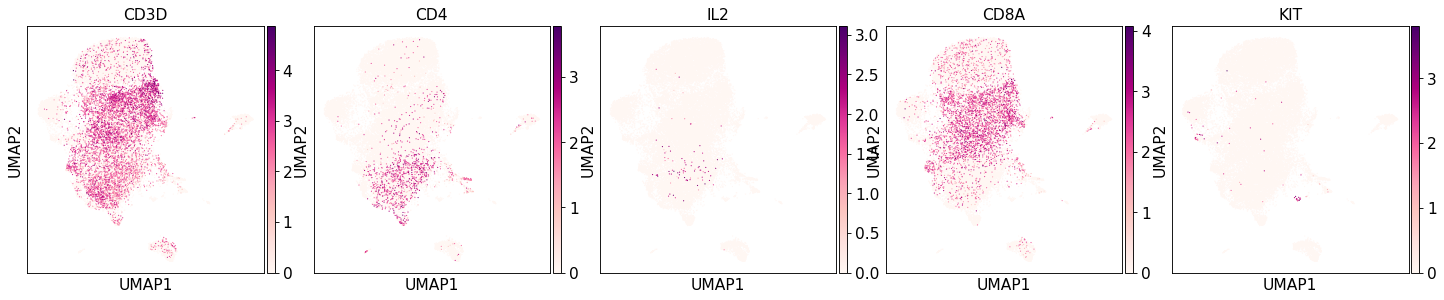

In [6]:
sc.pl.umap(integ, color=['CD3D','CD4','IL2','CD8A','KIT'], cmap='RdPu', wspace=0.1, ncols=5)

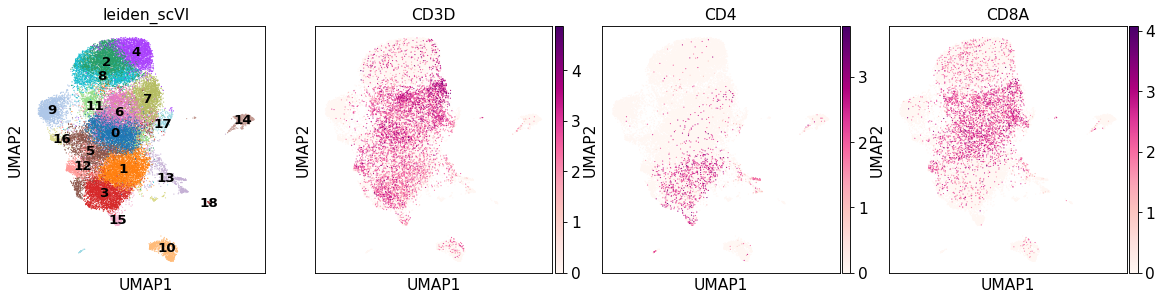

In [7]:
sc.pl.umap(integ, color=['leiden_scVI','CD3D','CD4','CD8A'], cmap='RdPu', wspace=0.1, ncols=5,legend_loc='on data',legend_fontsize=12)

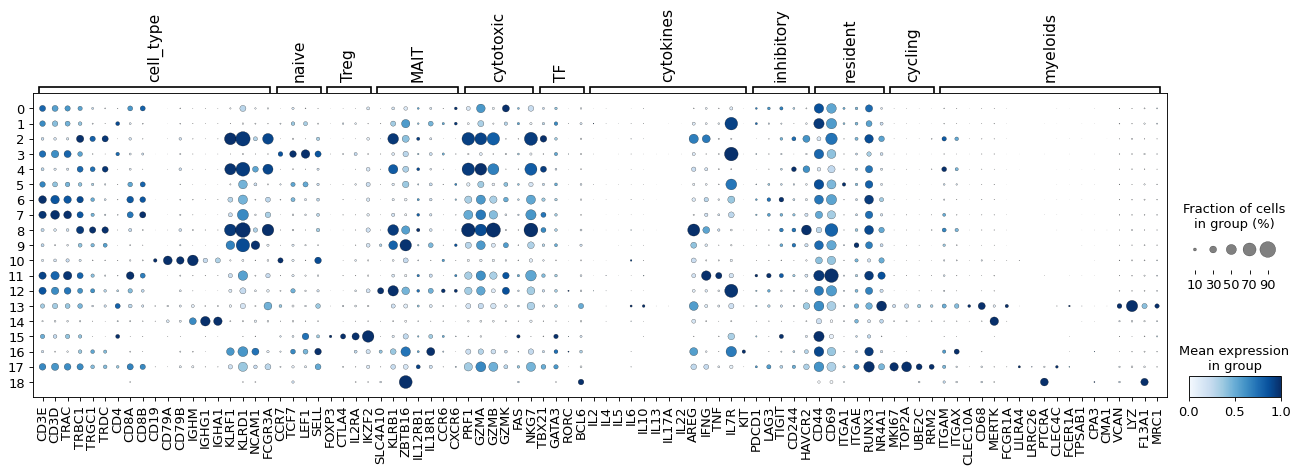

In [8]:
# markers genes
markers_df = pd.read_csv('/home/jovyan/data/genesets/Markers/marker-genes_210312.csv')

# remove categories
# markers_df = markers_df[markers_df['category']!='myeloids']

# remove genes, which are not in the dataset
for i in range(len(markers_df)):
    genes = markers_df.genes[i].split(',')
    pos = [x in integ.var_names for x in genes]
    genes = [genes[x] for x in np.where(pos)[0]]
    markers_df.genes[i] = ','.join(genes).split(',')
    
# convert to dictionary
markers_dict = markers_df.set_index('category').T.to_dict('list')

for key in markers_dict.keys():
    markers_dict[key] = list(np.array(markers_dict[key])[0])

# plot
sc.pl.dotplot(
    integ,
    markers_dict,
    groupby='leiden_scVI',
    dendrogram=False,
    # categories_order = lymphocytes_order,
    color_map="Blues",
    standard_scale="var",
    figsize=[20, 5]
)

In [9]:
integ.obs['cell_states_20210305'] = integ.obs['leiden_scVI']
integ.obs['cell_states_20210305'] = integ.obs['cell_states_20210305'].astype('str')
integ.obs.replace({'cell_states_20210305': {
    '0': 'CD8T_1',
    '1': 'CD4T_act',
    '2': 'NK_1',
    '3': 'CD4T_naive',
    '4': 'NK_2',
    '5': 'CD8T_2',
    '6': 'CD8T_4',
    '7': 'CD8T_3',
    '8': 'NK_3',
    '9': 'NK_CD56hi',
    '10': 'B',
    '11': 'CD8T_5',
    '12': 'MAIT-like',
    '13': 'unclassified.1',
    '14': 'Plasma',
    '15': 'CD4T_reg',
    '16': 'ILC',
    '17': 'prolif_Lymphoids',
    '18': 'unclassified.2',
}}, inplace=True)
integ.obs['cell_states_20210305'] = integ.obs['cell_states_20210305'].astype('category')

## Remove HCA-cell data

/home/jovyan/my-conda-envs/kk14-env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


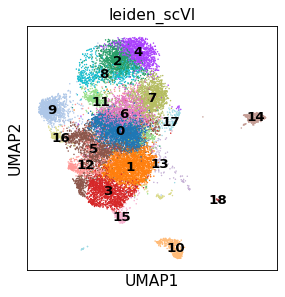

In [10]:
DCM = integ[integ.obs['data']=='DCM']
sc.pl.umap(DCM, color=['leiden_scVI'], cmap='RdPu', wspace=0.1, ncols=5,legend_loc='on data',legend_fontsize=12)

## NK annotation

Trying to set attribute `.uns` of view, copying.


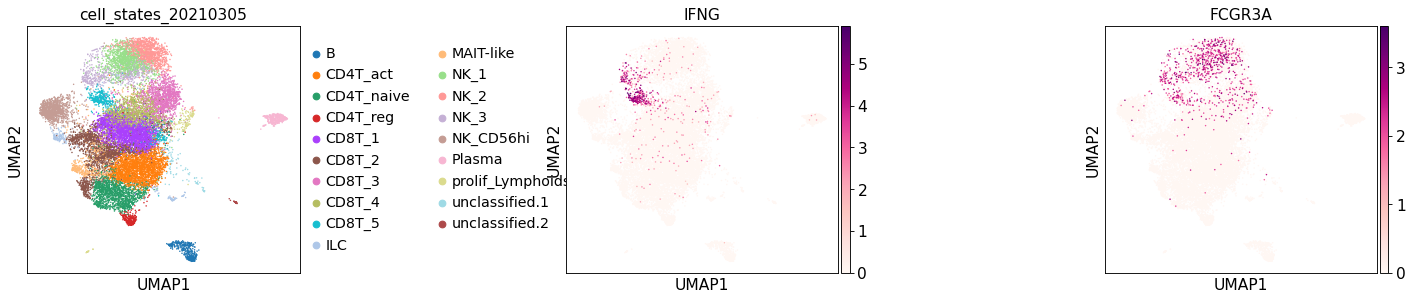

In [11]:
sc.pl.umap(DCM, color=['cell_states_20210305','IFNG','FCGR3A'], cmap='RdPu', wspace=0.8, ncols=5)

In [12]:
DCM.obs['cell_states_20210305'] = DCM.obs['cell_states_20210305'].astype('str')
DCM.obs.replace({'cell_states_20210305': {
    'NK_1': 'NK_CD16hi',
    'NK_2': 'NK_CD16hi',
    'NK_3': 'NK_CD16hiIFNGhi',
}}, inplace=True)
DCM.obs['cell_states_20210305'] = DCM.obs['cell_states_20210305'].astype('category')

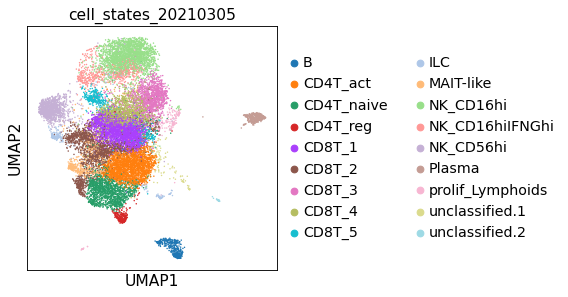

In [13]:
sc.pl.umap(DCM, color=['cell_states_20210305'], cmap='RdPu', wspace=0.8, ncols=5)

## CD8T annotation

Trying to set attribute `.obs` of view, copying.


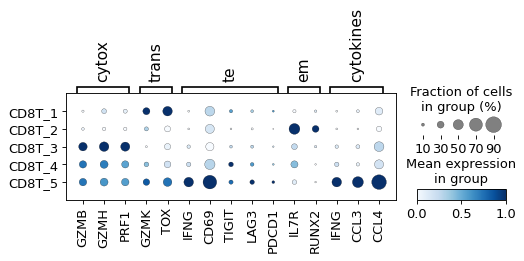

In [14]:
CD8T = integ[integ.obs['cell_states_20210305'].isin(['CD8T_1','CD8T_2','CD8T_3','CD8T_4','CD8T_5'])]
CD8T.obs['cell_states_20210305'] = CD8T.obs['cell_states_20210305'].astype('str')
CD8T.obs['cell_states_20210305'] = CD8T.obs['cell_states_20210305'].astype('category')
markers_dict = {
    'cytox': ['GZMB', 'GZMH', 'PRF1'],
    'trans': ['GZMK','TOX'],
    'te': ['IFNG', 'CD69', 'TIGIT', 'LAG3', 'PDCD1'],
    'em': ['IL7R','RUNX2'],
    'cytokines':['IFNG','CCL3','CCL4']
}

sc.pl.dotplot(
    CD8T,
    markers_dict,
    dendrogram=False,
    groupby="cell_states_20210305",
    color_map="Blues",
    standard_scale="var",
)

In [15]:
integ.obs['cell_states_20210305'] = integ.obs['cell_states_20210305'].astype('str')
integ.obs.replace({'cell_states_20210305': {
    'CD8T_3': 'CD8T_cytox',
    'CD8T_4': 'CD8T_te',
    'CD8T_5': 'CD8T_te_IFNGhi',
    'CD8T_2': 'CD8T_em',
    'CD8T_1': 'CD8T_trans',
}}, inplace=True)
integ.obs['cell_states_20210305'] = integ.obs['cell_states_20210305'].astype('category')

In [16]:
DCM.obs['cell_states_20210305'] = DCM.obs['cell_states_20210305'].astype('str')
DCM.obs.replace({'cell_states_20210305': {
    'CD8T_3': 'CD8T_cytox',
    'CD8T_4': 'CD8T_te',
    'CD8T_5': 'CD8T_te_IFNGhi',
    'CD8T_2': 'CD8T_em',
    'CD8T_1': 'CD8T_trans',
}}, inplace=True)
DCM.obs['cell_states_20210305'] = DCM.obs['cell_states_20210305'].astype('category')

/home/jovyan/my-conda-envs/kk14-env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


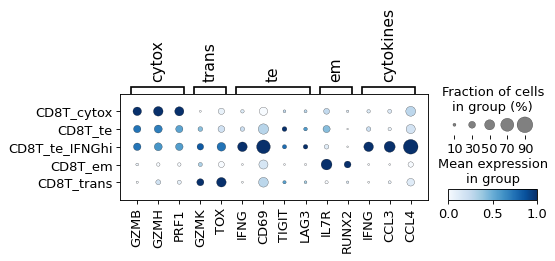

In [17]:
CD8T = integ[integ.obs['cell_states_20210305'].isin(['CD8T_cytox','CD8T_te','CD8T_te_IFNGhi','CD8T_em','CD8T_trans'])]
CD8T.obs['cell_states_20210305'] = CD8T.obs['cell_states_20210305'].astype('str')
CD8T.obs['cell_states_20210305'] = CD8T.obs['cell_states_20210305'].astype('category')
markers_dict = {
    'cytox': ['GZMB', 'GZMH', 'PRF1'],
    'trans': ['GZMK','TOX'],
    'te': ['IFNG', 'CD69', 'TIGIT', 'LAG3'],
    'em': ['IL7R','RUNX2'],
    'cytokines':['IFNG','CCL3','CCL4']
}

sc.pl.dotplot(
    CD8T,
    markers_dict,
    dendrogram=False,
    categories_order=['CD8T_cytox','CD8T_te','CD8T_te_IFNGhi','CD8T_em','CD8T_trans'],
    groupby="cell_states_20210305",
    color_map="Blues",
    standard_scale="var",
)

In [ ]:
sc.tl.rank_genes_groups(CD8T, 'cell_states_20210305', method='wilcoxon')

sc.tl.dendrogram(CD8T, groupby='cell_states_20210305')
sc.pl.dotplot(
    CD8T,
    pd.DataFrame(CD8T.uns['rank_genes_groups']['names'])[:15].to_dict('list'),
    groupby="cell_states_20210305",
    color_map="Blues",
    standard_scale="var",
    dendrogram=True,
)

In [19]:
# correlation analysis
## aggregate each cluster
aggr = {}
for state in CD8T.obs['cell_states_20210305'].cat.categories:
    subset = CD8T[CD8T.obs['cell_states_20210305'].isin([state])]
    aggr[state] = np.squeeze(np.asarray(subset.X.mean(axis=0)))
    del subset

## calculate correlation
aggr=pd.DataFrame.from_dict(aggr)
# aggr['genes']=CD8T.var.index # if you want to put gene names
aggr.corr(method='pearson').style.background_gradient(cmap='RdPu')

/home/jovyan/my-conda-envs/kk14-env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


,CD8T_cytox,CD8T_em,CD8T_te,CD8T_te_IFNGhi,CD8T_trans
CD8T_cytox,1.000000,0.908034,0.977949,0.951908,0.933263
CD8T_em,0.908034,1.000000,0.909970,0.883860,0.981001
CD8T_te,0.977949,0.909970,1.000000,0.962180,0.932347
CD8T_te_IFNGhi,0.951908,0.883860,0.962180,1.000000,0.914117
CD8T_trans,0.933263,0.981001,0.932347,0.914117,1.000000


## Visualise full annotation and markers: integrated object

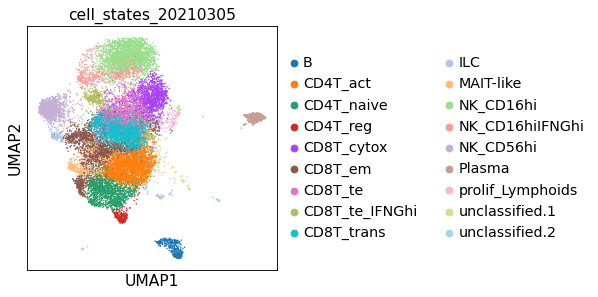

In [20]:
sc.pl.umap(DCM, color=['cell_states_20210305'], cmap='RdPu', wspace=0.8, ncols=5)

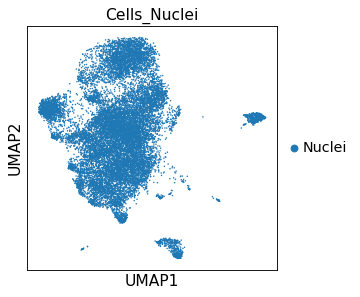

In [21]:
sc.pl.umap(DCM, color=['Cells_Nuclei'], cmap='RdPu', wspace=0.8, ncols=5)

In [22]:
order = ['B', 'Plasma', 'CD4T_naive','CD4T_act','CD4T_reg',
       'CD8T_cytox', 'CD8T_trans', 'CD8T_te', 'CD8T_te_IFNGhi', 'CD8T_em', 'MAIT-like',
       'NK_CD16hi', 'NK_CD16hiIFNGhi', 'NK_CD56hi','ILC','prolif_Lymphoids', 'unclassified.1', 'unclassified.2']

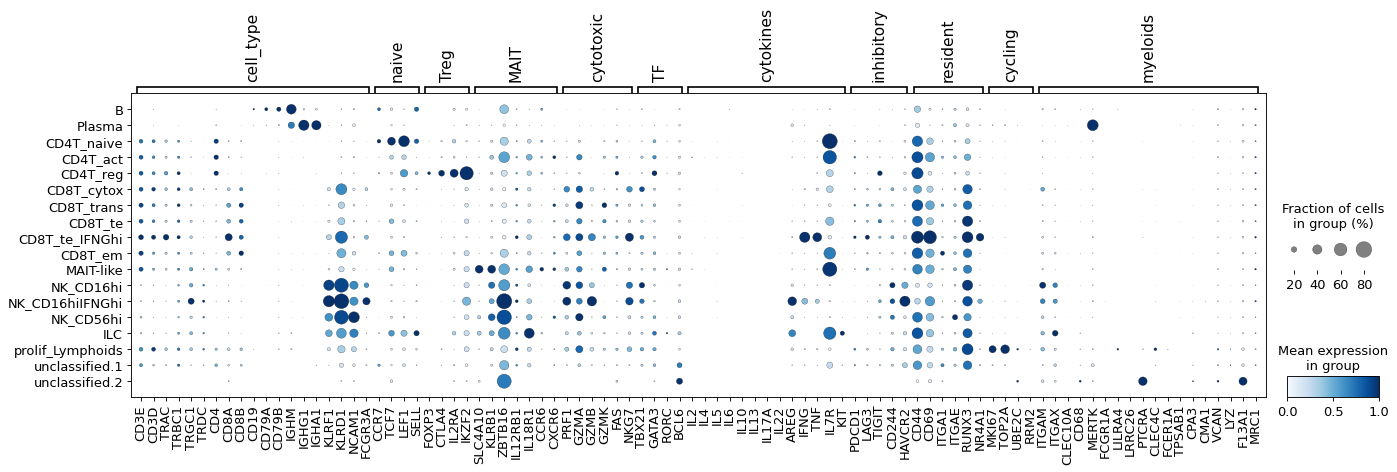

In [23]:
# markers genes
markers_df = pd.read_csv('/home/jovyan/data/genesets/Markers/marker-genes_210312.csv')

# remove categories
# markers_df = markers_df[markers_df['category']!='myeloids']

# remove genes, which are not in the dataset
for i in range(len(markers_df)):
    genes = markers_df.genes[i].split(',')
    pos = [x in integ.var_names for x in genes]
    genes = [genes[x] for x in np.where(pos)[0]]
    markers_df.genes[i] = ','.join(genes).split(',')
    
# convert to dictionary
markers_dict = markers_df.set_index('category').T.to_dict('list')

for key in markers_dict.keys():
    markers_dict[key] = list(np.array(markers_dict[key])[0])

# plot
sc.pl.dotplot(
    DCM,
    markers_dict,
    groupby='cell_states_20210305',
    dendrogram=False,
    categories_order = order,
    color_map="Blues",
    standard_scale="var",
    figsize=[20, 5]
)

## Visualise full annotation and markers: DCM object

In [24]:
DCM.obs['cell_states_20210305'] = DCM.obs['cell_states_20210305'].astype('category')
DCM.obs['cell_states_20210305'].cat.reorder_categories(new_categories=['B', 'Plasma', 'CD4T_naive','CD4T_act','CD4T_reg',
                                                                       'CD8T_cytox', 'CD8T_trans', 'CD8T_te', 'CD8T_te_IFNGhi', 'CD8T_em', 'MAIT-like',
                                                                       'NK_CD16hi', 'NK_CD16hiIFNGhi', 'NK_CD56hi','ILC','prolif_Lymphoids', 'unclassified.1', 'unclassified.2'], 
                                                       inplace=True)

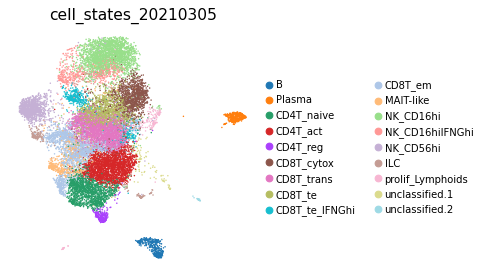

In [25]:
sc.pl.umap(DCM, color=['cell_states_20210305'], cmap='RdPu', wspace=0.8, ncols=5, frameon=False, legend_fontsize=9)

## Clean up `obs.columns`, change cell_states column name, and save

In [28]:
# clean up .obs.columns
DCM.obs = DCM.obs[['Sample', 'Patient', 'Gender', 'Region', 'Diagnosis', 'Gene', 'Clinical.dominant.mutation',
                   'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'scrublet_score_z', 'scrublet_score_log', 'solo_score',
                   'cell_type', 'cell_states_20210305']]

# change column name for cell_states
DCM.obs.rename(columns={'cell_states_20210305':'cell_states'}, inplace=True)
DCM.obs.columns

Index(['Sample', 'Patient', 'Gender', 'Region', 'Diagnosis', 'Gene',
       'Clinical.dominant.mutation', 'n_genes', 'n_counts', 'percent_mito',
       'percent_ribo', 'scrublet_score_z', 'scrublet_score_log', 'solo_score',
       'cell_type', 'cell_states'],
      dtype='object')

In [29]:
# save
DCM.write('/nfs/team205/kk18/DCM/anndata/Lymphoid_annotated_scVI-UMAP_210513.h5ad')

### Save `obs` as metadata sheet

In [ ]:
# make the DCM barcodes same as original one (in a secure way)
barcode_dict = dict()
for old in DCM.obs_names:
    x = old.rstrip('-DCM')
    barcode_dict[old] = x
    del x
    
DCM.obs.rename(index=barcode_dict, inplace=True)

In [ ]:
adata_rmDoublets = sc.read_h5ad('/nfs/team205/kk18/DCM/anndata/Lymphoid_20210305_V1_RAW_doublet-removed.h5ad')
adata_rmDoublets.obs = pd.concat([adata_rmDoublets.obs, DCM.obs[['cell_states']].reindex(adata_rmDoublets.obs.index)], axis=1)

In [36]:
adata_rmDoublets.obs.to_csv('/home/jovyan/projects/kk14_DCM-lymphoid/metadata_sheet/Lymphoid_20210305_V1_META_NODOUBLETS_kazumasa20210513.csv')

## Figures

### Read in annotated anndata

In [3]:
DCM = sc.read_h5ad('/nfs/team205/kk18/DCM/anndata/Lymphoid_annotated_scVI-UMAP_210513.h5ad')

# remove unclassified cells
DCM = DCM[DCM.obs['cell_states'].isin(['unclassified.1','unclassified.2'])==False]

# replace 'mutation negative' with 'PVneg'
DCM.obs.replace({'Gene':{
    'mutation negative':'PVneg'
}}, inplace=True)
DCM

/home/jovyan/my-conda-envs/kk14-env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


View of AnnData object with n_obs × n_vars = 16726 × 25134
    obs: 'Sample', 'Patient', 'Gender', 'Region', 'Diagnosis', 'Gene', 'Clinical.dominant.mutation', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'scrublet_score_z', 'scrublet_score_log', 'solo_score', 'cell_type', 'cell_states'
    var: 'gene_ids-DCM', 'feature_types-DCM', 'genome-DCM', 'gene_ids-Harvard-Nuclei-HCA', 'feature_types-Harvard-Nuclei-HCA', 'gene_ids-Sanger-Nuclei-HCA', 'feature_types-Sanger-Nuclei-HCA', 'gene_ids-Sanger-Cells-HCA', 'feature_types-Sanger-Cells-HCA', 'gene_ids-Sanger-CD45-HCA', 'feature_types-Sanger-CD45-HCA', 'n_counts'
    uns: 'Cells_Nuclei_colors', '_scvi', 'cell_states_20210305_colors', 'hvg', 'leiden', 'leiden_scVI_colors', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

### UMAP

Trying to set attribute `.uns` of view, copying.


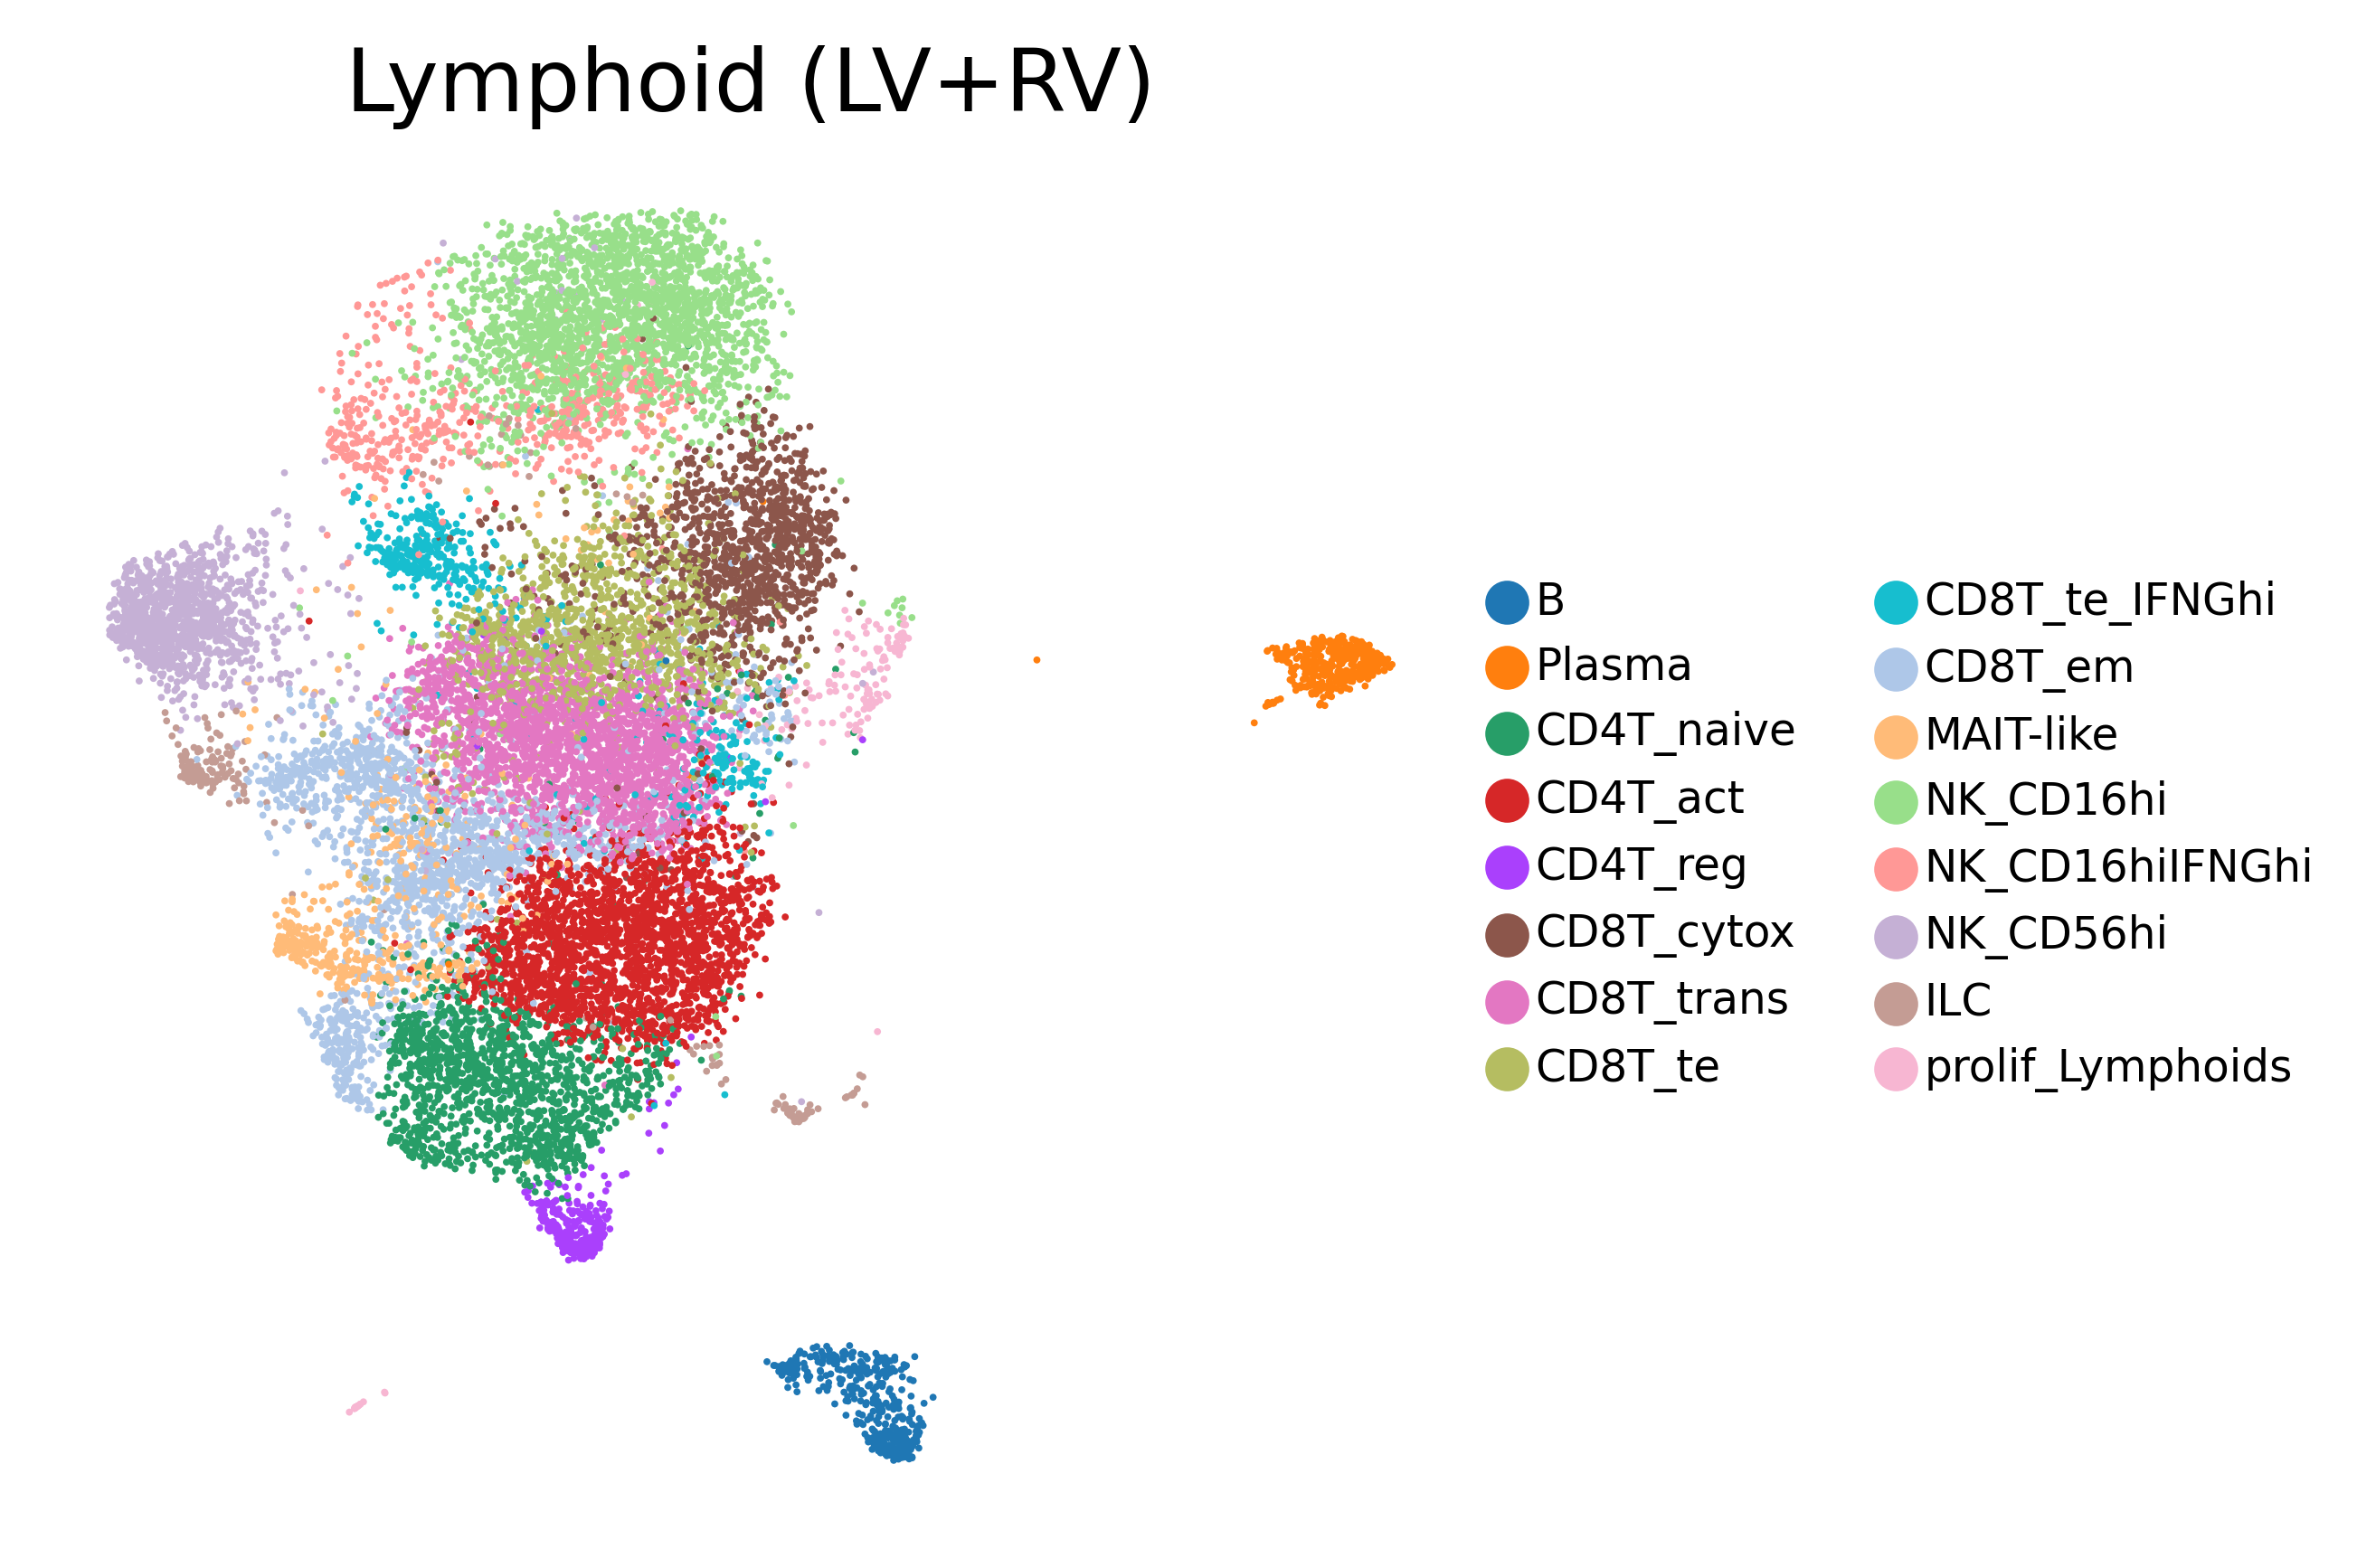

In [4]:
sc.settings.set_figure_params(dpi=500, facecolor='white')
sc.pl.umap(DCM, color=['cell_states'], title="Lymphoid (LV+RV)", legend_fontsize='7', frameon=False, size=5,
          save='Fig4F_UMAP.png'
          )


### Lymphocyte marker genes expressions

/home/jovyan/my-conda-envs/kk14-env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


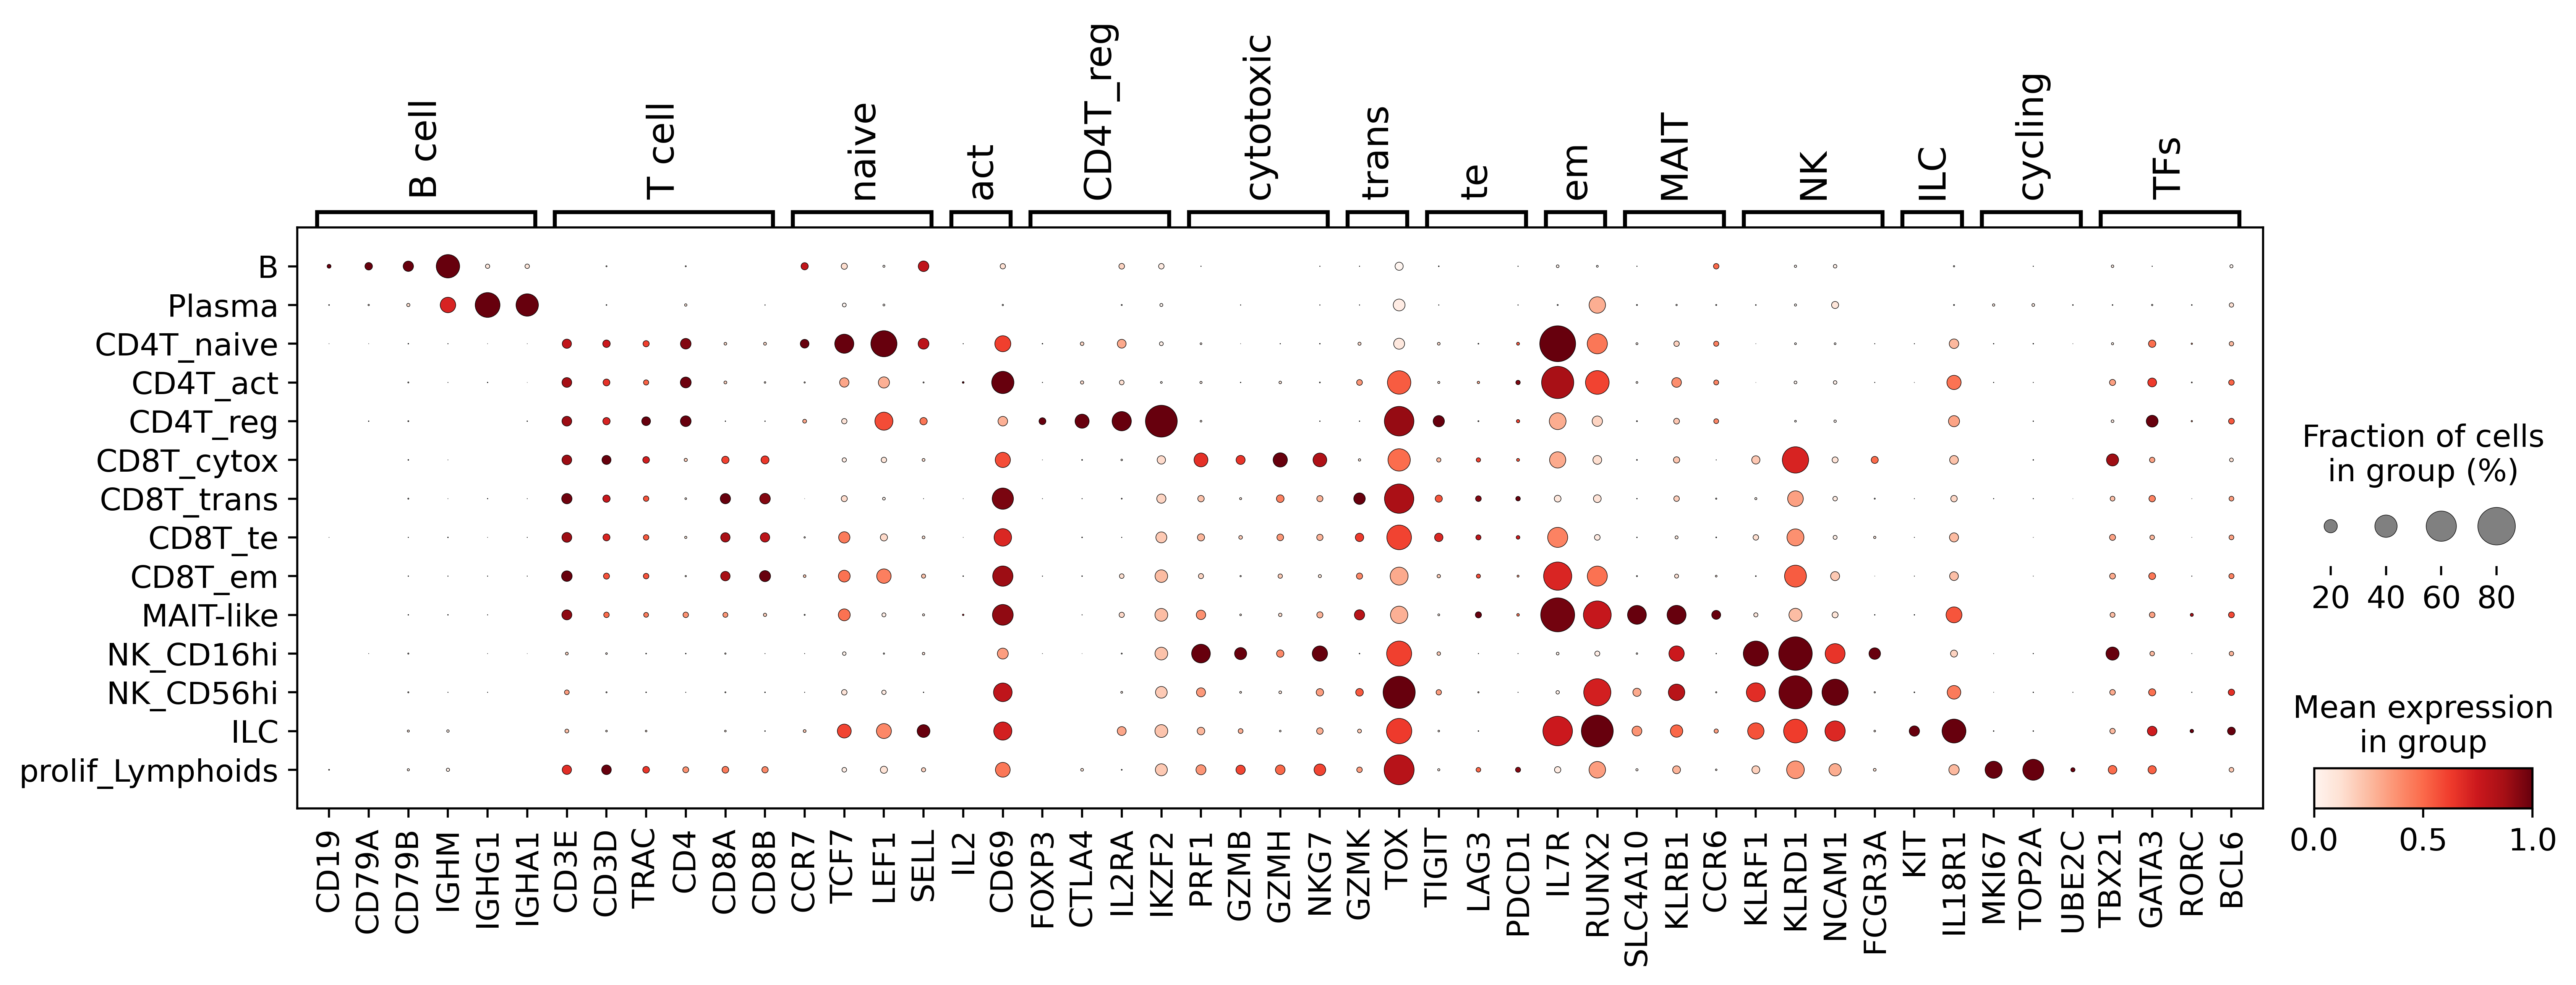

In [5]:
markers_dict={
    'B cell': ['CD19', 'CD79A', 'CD79B', 'IGHM', 'IGHG1', 'IGHA1'],
    'T cell': ['CD3E', 'CD3D', 'TRAC', 'CD4', 'CD8A', 'CD8B'],
    'naive': ['CCR7', 'TCF7', 'LEF1', 'SELL'],
    'act': ['IL2','CD69'],
    'CD4T_reg': ['FOXP3', 'CTLA4', 'IL2RA', 'IKZF2'],
    'cytotoxic': ['PRF1', 'GZMB', 'GZMH', 'NKG7'],
    'trans': ['GZMK', 'TOX'],
    'te': ['TIGIT', 'LAG3', 'PDCD1'],
    'em': ['IL7R', 'RUNX2'],
    'MAIT': ['SLC4A10', 'KLRB1', 'CCR6'],
    'NK': ['KLRF1', 'KLRD1', 'NCAM1', 'FCGR3A'],
    'ILC': ['KIT', 'IL18R1'],
    'cycling': ['MKI67', 'TOP2A', 'UBE2C'],
    'TFs': ['TBX21', 'GATA3', 'RORC', 'BCL6',],
}

# plot
sc.set_figure_params(scanpy=True, fontsize=7)
sc.settings.set_figure_params(dpi=500, facecolor='white')
sc.pl.dotplot(
    DCM[DCM.obs['cell_states'].isin(['CD8T_te_IFNGhi','NK_CD16hiIFNGhi'])==False], # remove outlier IFNGhi cells
    markers_dict,
    groupby='cell_states',
    color_map="Reds",
    standard_scale="var",
    figsize=[15, 4],
    save='SupFig16A_marker.png'
)